In [2]:
import pandas as pd
import re
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os
import json

# Directory containing the JSON files
# json_directory = "/path/to/json/files"
json_directory='/home/dgarg39/flame/lib/python/examples/async_cifar10/trainer/config_dir1_num300_traceFail_6d_3state_oort/'


# Dictionary to store trainer_id and training_delay
trainer_delay_dict = {}

# Iterate over each file with the naming pattern trainer_x.json
for i in range(1, 301):  # Loop from 1 to 300
    filename = f"trainer_{i}.json"  # Create the filename based on the pattern
    filepath = os.path.join(json_directory, filename)
    
    # Check if the file exists (to handle any missing files)
    if os.path.isfile(filepath):
        # Open and load the JSON file
        with open(filepath, 'r') as file:
            try:
                data = json.load(file)
                
                # Check if the JSON file contains 'trainer_id' and 'training_delay'
                trainer_id = data.get("taskid")
                training_delay = float(data.get("hyperparameters").get("training_delay_s"))
                
                # Add to the dictionary if both values are present
                if trainer_id is not None and training_delay is not None:
                    trainer_delay_dict[trainer_id] = training_delay

            except json.JSONDecodeError:
                print(f"Could not decode JSON in file: {filename}")
    else:
        print(f"File {filename} does not exist.")

# Print the resulting dictionary of trainer_id and training_delay
print("Trainer ID to Training Delay Dictionary:")
print(trainer_delay_dict)

Trainer ID to Training Delay Dictionary:
{'505f9fc483cf4df68a2409257b5fad7d3c580370': 4.0, '505f9fc483cf4df68a2409257b5fad7d3c580371': 16.0, '505f9fc483cf4df68a2409257b5fad7d3c580372': 13.0, '505f9fc483cf4df68a2409257b5fad7d3c580373': 7.0, '505f9fc483cf4df68a2409257b5fad7d3c580374': 18.0, '505f9fc483cf4df68a2409257b5fad7d3c580375': 5.0, '505f9fc483cf4df68a2409257b5fad7d3c580376': 10.0, '505f9fc483cf4df68a2409257b5fad7d3c580377': 17.0, '505f9fc483cf4df68a2409257b5fad7d3c580378': 13.0, '505f9fc483cf4df68a2409257b5fad7d3c580379': 11.0, '505f9fc483cf4df68a2409257b5fad7d3c580380': 11.0, '505f9fc483cf4df68a2409257b5fad7d3c580381': 19.0, '505f9fc483cf4df68a2409257b5fad7d3c580382': 10.0, '505f9fc483cf4df68a2409257b5fad7d3c580383': 3.0, '505f9fc483cf4df68a2409257b5fad7d3c580384': 6.0, '505f9fc483cf4df68a2409257b5fad7d3c580385': 13.0, '505f9fc483cf4df68a2409257b5fad7d3c580386': 14.0, '505f9fc483cf4df68a2409257b5fad7d3c580387': 9.0, '505f9fc483cf4df68a2409257b5fad7d3c580388': 2.0, '505f9fc483cf4d

In [4]:
def get_avg_utility_staleness_vs_rounds(filename, total_rounds):
    aggregation_pattern = r".*aggregation finished for round.*"
    received_weights_pattern = r".*Received weights from ([a-f0-9]+).*"
    received_eval_pattern = r".*received eval message .* from ([a-f0-9]+).*"
    sending_weights_pattern = r"sending weights to ([a-f0-9]+) with model_version: (\d+) for task: train"
    # specific_stop_pattern = r".*aggregation finished for round 1000.*"
    specific_stop_pattern = rf".*aggregation finished for round {total_rounds}.*"


    combined_pattern = f"{aggregation_pattern}|{received_weights_pattern}|{received_eval_pattern}|{sending_weights_pattern}"

    filtered_logs = []
    with open(filename, 'r') as file:
        for line in file:
            if re.search(combined_pattern, line):
                filtered_logs.append(line)
            # Check for the specific line to stop
            if re.search(specific_stop_pattern, line):
                break


    # Display the filtered logs
    print(len(filtered_logs))
    trainers_picked_per_round = defaultdict(list)
    # trainers_aggregated_per_round = defaultdict(list)
    # select_round_per_trainer = {}
    # aggregate_round_per_trainer = {}
    # avg_utility_staleness_per_round = {}
    # round_number = 1001
    # total_utility_staleness = 0
    # avg_utility_staleness = 0
    # trainers_considered = 0
    for line in filtered_logs:
        # print(line)
        # if re.search(aggregation_pattern,line):        
            # if trainers_considered >0:
                # avg_utility_staleness = total_utility_staleness/len(trainers_picked_per_round[round_number])
            #     avg_utility_staleness = total_utility_staleness/trainers_considered
            # avg_utility_staleness_per_round[round_number] = avg_utility_staleness
            # round_number+=1
            # total_utility_staleness = 0
            # avg_utility_staleness = 0
            # trainers_considered = 0

            
        if re.search(sending_weights_pattern, line):
            match = re.search(sending_weights_pattern, line)
            trainer_id = match.group(1)
            model_version = int(match.group(2))
            trainers_picked_per_round[model_version].append(trainer_id)
            # select_round_per_trainer[trainer_id] = model_version
            # if trainer_id in aggregate_round_per_trainer:
            #     utility_staleness = model_version - aggregate_round_per_trainer[trainer_id]
            #     trainers_considered += 1
                # total_utility_staleness += utility_staleness
        # else:
        #     match = re.search(received_weights_pattern, line) or re.search(received_eval_pattern, line)
        #     trainer_id = match.group(1)
        #     trainers_aggregated_per_round[round_number].append(trainer_id)
        #     aggregate_round_per_trainer[trainer_id] = round_number

    average_delay_per_round = {}

    # Calculate the average delay per round
    for round_num, trainers in trainers_picked_per_round.items():
        delays = [trainer_delay_dict[trainer] for trainer in trainers if trainer in trainer_delay_dict]
        
        # Calculate average delay if there are valid delays
        if delays:
            average_delay = sum(delays) / len(delays)
            average_delay_per_round[round_num] = average_delay
        else:
            average_delay_per_round[round_num] = 0  # or 0, or any indicator for no data

    # Print the average delay per round
    print("Average Delay per Round:")
    print(average_delay_per_round)
    return average_delay_per_round

    # return avg_utility_staleness_per_round




In [5]:
def aggregate_values(avg_utility_staleness_per_round):
    x = list(avg_utility_staleness_per_round.keys())
    y = list(avg_utility_staleness_per_round.values())
    interval = 50
    x_aggregated = x[::interval]
    y_aggregated = [np.mean(y[i:i+interval]) for i in range(0, len(y), interval)]
    return x_aggregated, y_aggregated

58196
Average Delay per Round:
{1: 11.363636363636363, 2: 11.916666666666666, 3: 10.0, 4: 9.454545454545455, 5: 10.083333333333334, 6: 9.363636363636363, 7: 8.363636363636363, 8: 9.0, 9: 13.545454545454545, 10: 7.363636363636363, 11: 9.0, 12: 10.3, 13: 8.272727272727273, 14: 10.272727272727273, 15: 8.727272727272727, 16: 11.8, 17: 10.272727272727273, 18: 8.3, 19: 10.3, 20: 8.545454545454545, 21: 8.454545454545455, 22: 9.6, 23: 11.636363636363637, 24: 7.909090909090909, 25: 12.7, 26: 10.4, 27: 8.272727272727273, 28: 10.9, 29: 8.8, 30: 10.090909090909092, 31: 8.777777777777779, 32: 9.181818181818182, 33: 11.181818181818182, 34: 10.4, 35: 9.727272727272727, 36: 8.636363636363637, 37: 9.3, 38: 7.818181818181818, 39: 11.0, 40: 8.9, 41: 8.6, 42: 11.545454545454545, 43: 9.2, 44: 9.8, 45: 10.272727272727273, 46: 8.9, 47: 9.818181818181818, 48: 8.818181818181818, 49: 10.4, 50: 8.545454545454545, 51: 12.4, 52: 10.11111111111111, 53: 12.181818181818182, 54: 7.0, 55: 11.5, 56: 8.363636363636363, 5

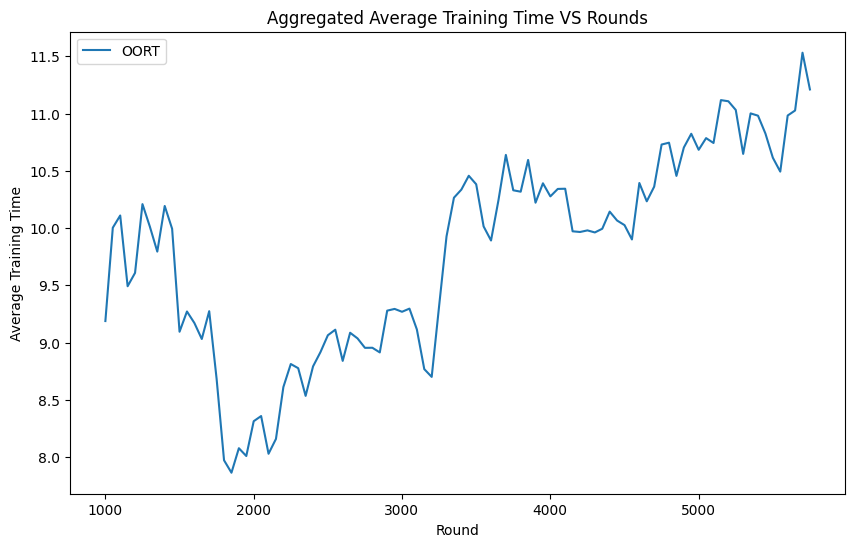

In [6]:
# oort_agg_logs_alpha1 = 'dup_agg_jayne_29_10_17_12_alpha1_cifar_70acc_fedbuff_asyncoort_clientNotify_50.log'
# felix_agg_logs_alpha1 = 'dup_agg_sheph_29_10_16_54_alpha1_cifar_70acc_IAgg_ISel_clientNotify_50.log'
oort_agg_logs_alpha1 = 'filtered4_oort_alpha1.log'
felix_agg_logs_alpha1 = 'filtered4_felix_alpha1.log'
oort_output = get_avg_utility_staleness_vs_rounds(oort_agg_logs_alpha1, 2000)
# felix_output = get_avg_utility_staleness_vs_rounds(felix_agg_logs_alpha1)
x, y = aggregate_values(oort_output)
x_oort = [value for value in x if value >= 1000]
y_oort = y[len(y) - len(x_oort):] 
# x_felix, y_felix = aggregate_values(felix_output)
# x_oort = list(oort_output.keys())
# y_oort = list(oort_output.values())

plt.figure(figsize=(10, 6))
plt.plot(x_oort, y_oort, label='OORT')
# plt.plot(x_felix, y_felix, label='FeLiX')
plt.xlabel("Round")
plt.ylabel("Average Training Time")
plt.title("Aggregated Average Training Time VS Rounds")
plt.legend()
# plt.ylim(0,4)
plt.show()

38627
Average Delay per Round:
{1: 11.363636363636363, 2: 11.916666666666666, 3: 10.0, 4: 9.454545454545455, 5: 10.083333333333334, 6: 9.363636363636363, 7: 8.363636363636363, 8: 8.11111111111111, 9: 13.909090909090908, 10: 8.538461538461538, 11: 6.8, 12: 9.1, 13: 8.090909090909092, 14: 10.916666666666666, 15: 9.0, 16: 9.818181818181818, 17: 10.071428571428571, 18: 13.533333333333333, 19: 10.923076923076923, 20: 11.0, 21: 10.785714285714286, 22: 7.866666666666666, 23: 10.3, 24: 7.111111111111111, 25: 10.538461538461538, 26: 12.181818181818182, 27: 12.727272727272727, 28: 10.0, 29: 8.4, 30: 13.7, 31: 9.916666666666666, 32: 7.333333333333333, 33: 5.111111111111111, 34: 10.636363636363637, 35: 13.928571428571429, 36: 12.916666666666666, 37: 9.333333333333334, 38: 10.166666666666666, 39: 11.545454545454545, 40: 9.785714285714286, 41: 10.9, 42: 12.88888888888889, 43: 9.916666666666666, 44: 11.0, 45: 13.071428571428571, 46: 12.555555555555555, 47: 10.909090909090908, 48: 11.923076923076923, 

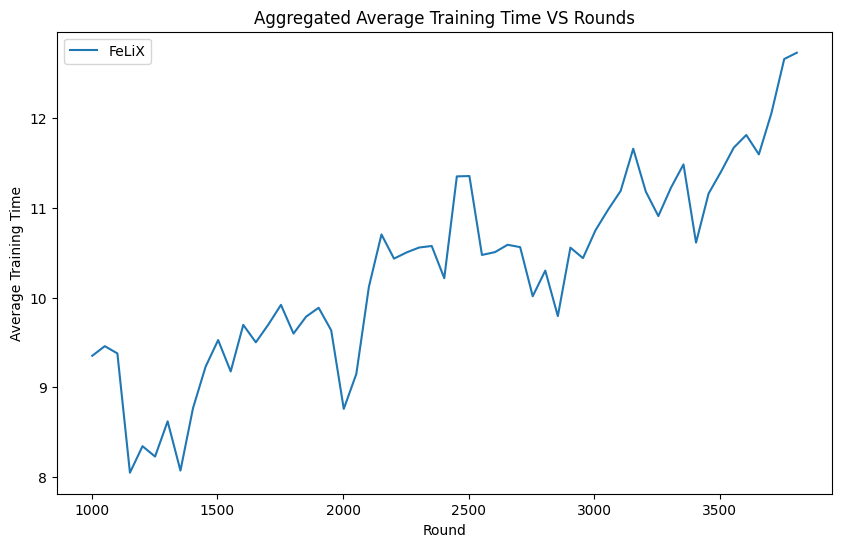

In [9]:
# oort_agg_logs_alpha1 = 'agg_jayne_29_10_17_12_alpha1_cifar_70acc_fedbuff_asyncoort_clientNotify_50.log'
# felix_agg_logs_alpha1 = 'agg_sheph_29_10_16_54_alpha1_cifar_70acc_IAgg_ISel_clientNotify_50.log'
# oort_output = get_avg_utility_staleness_vs_rounds(oort_agg_logs_alpha1)
felix_output = get_avg_utility_staleness_vs_rounds(felix_agg_logs_alpha1, 2000)
# x_oort, y_oort = aggregate_values(oort_output)
x, y = aggregate_values(felix_output)
x_felix = [value for value in x if value >= 1000]
y_felix = y[len(y) - len(x_felix):] 

plt.figure(figsize=(10, 6))
# plt.plot(x_oort, y_oort, label='OORT')
plt.plot(x_felix, y_felix, label='FeLiX')
plt.xlabel("Round")
plt.ylabel("Average Training Time")
plt.title("Aggregated Average Training Time VS Rounds")
plt.legend()
# plt.ylim(0,4)
plt.show()

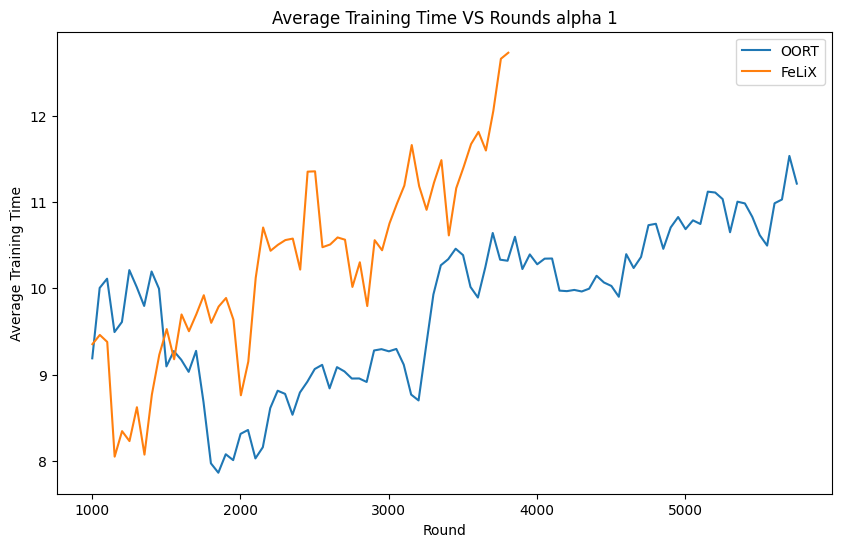

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(x_oort, y_oort, label='OORT')
plt.plot(x_felix, y_felix, label='FeLiX')
plt.xlabel("Round")
plt.ylabel("Average Training Time")
plt.title("Average Training Time VS Rounds alpha 1")
plt.legend()
# plt.ylim(0,4)
plt.show()

109134
Average Delay per Round:
{1: 11.363636363636363, 2: 11.916666666666666, 3: 10.0, 4: 9.454545454545455, 5: 10.083333333333334, 6: 9.363636363636363, 7: 9.0, 8: 8.181818181818182, 9: 13.727272727272727, 10: 7.181818181818182, 11: 9.0, 12: 10.181818181818182, 13: 8.454545454545455, 14: 10.090909090909092, 15: 9.545454545454545, 16: 11.7, 17: 9.636363636363637, 18: 9.7, 19: 9.8, 20: 8.181818181818182, 21: 8.090909090909092, 22: 10.2, 23: 11.090909090909092, 24: 11.909090909090908, 25: 9.6, 26: 10.363636363636363, 27: 8.5, 28: 9.333333333333334, 29: 10.090909090909092, 30: 10.3, 31: 9.909090909090908, 32: 8.454545454545455, 33: 11.9, 34: 9.6, 35: 11.0, 36: 8.909090909090908, 37: 8.11111111111111, 38: 7.545454545454546, 39: 11.909090909090908, 40: 8.5, 41: 9.272727272727273, 42: 11.636363636363637, 43: 7.666666666666667, 44: 9.727272727272727, 45: 12.5, 46: 6.7, 47: 10.181818181818182, 48: 8.090909090909092, 49: 11.5, 50: 8.818181818181818, 51: 11.8, 52: 10.2, 53: 9.272727272727273, 5

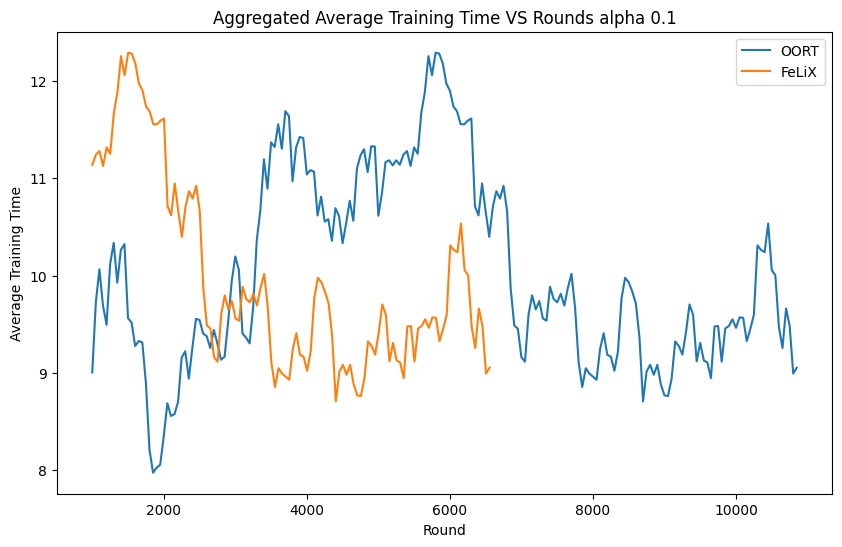

In [11]:
oort_agg_logs_alpha01 = 'filtered4_oort_alpha0.1.log'
felix_agg_logs_alpha01 = 'filtered4_felix_alpha0.1.log'
oort_output = get_avg_utility_staleness_vs_rounds(oort_agg_logs_alpha01, 2000)
felix_output = get_avg_utility_staleness_vs_rounds(felix_agg_logs_alpha01, 2000)
x, y = aggregate_values(oort_output)
x_oort = [value for value in x if value >= 1000]
y_oort = y[len(y) - len(x_oort):] 
x_f, y_f = aggregate_values(felix_output)
x_felix = [value for value in x_f if value >= 1000]
y_felix = y[len(y) - len(x_felix):] 
# x_oort = list(oort_output.keys())
# y_oort = list(oort_output.values())

plt.figure(figsize=(10, 6))
plt.plot(x_oort, y_oort, label='OORT')
plt.plot(x_felix, y_felix, label='FeLiX')
plt.xlabel("Round")
plt.ylabel("Average Training Time")
plt.title("Aggregated Average Training Time VS Rounds alpha 0.1")
plt.legend()
# plt.ylim(0,4)
plt.show()

53528
Average Delay per Round:
{1: 11.363636363636363, 2: 11.916666666666666, 3: 10.0, 4: 9.454545454545455, 5: 10.083333333333334, 6: 9.363636363636363, 7: 8.363636363636363, 8: 9.0, 9: 13.545454545454545, 10: 7.363636363636363, 11: 9.0, 12: 11.272727272727273, 13: 7.0, 14: 10.272727272727273, 15: 8.727272727272727, 16: 11.8, 17: 10.272727272727273, 18: 8.3, 19: 9.0, 20: 9.727272727272727, 21: 8.545454545454545, 22: 9.1, 23: 11.909090909090908, 24: 8.090909090909092, 25: 13.6, 26: 9.909090909090908, 27: 9.818181818181818, 28: 8.444444444444445, 29: 11.181818181818182, 30: 8.363636363636363, 31: 10.444444444444445, 32: 7.636363636363637, 33: 11.363636363636363, 34: 11.7, 35: 9.636363636363637, 36: 8.545454545454545, 37: 7.6, 38: 8.7, 39: 10.636363636363637, 40: 9.333333333333334, 41: 8.818181818181818, 42: 11.909090909090908, 43: 8.0, 44: 11.7, 45: 8.9, 46: 9.777777777777779, 47: 8.9, 48: 7.0, 49: 13.0, 50: 8.818181818181818, 51: 11.6, 52: 10.333333333333334, 53: 9.0, 54: 11.4545454545

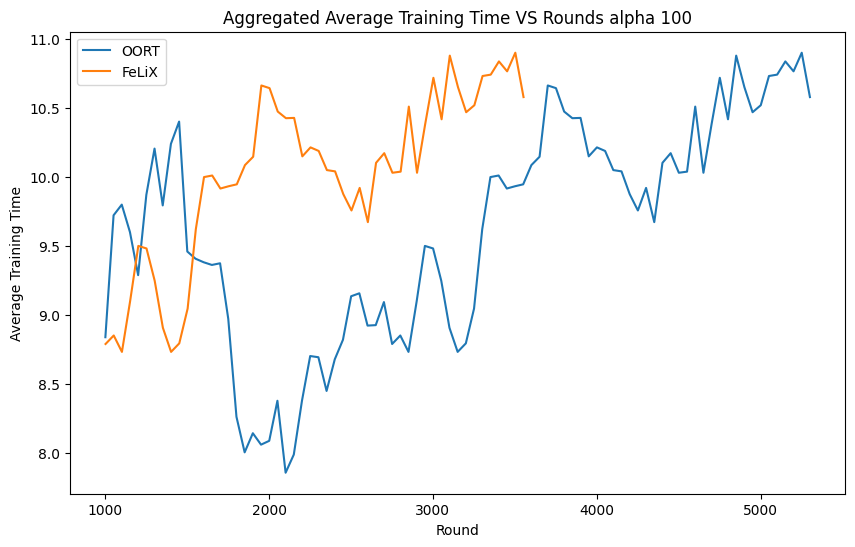

In [12]:
oort_agg_logs_alpha100 = 'filtered4_oort_alpha100.log'
felix_agg_logs_alpha100 = 'filtered4_felix_alpha100.log'
oort_output = get_avg_utility_staleness_vs_rounds(oort_agg_logs_alpha100, 2000)
felix_output = get_avg_utility_staleness_vs_rounds(felix_agg_logs_alpha100, 2000)
x, y = aggregate_values(oort_output)
x_oort = [value for value in x if value >= 1000]
y_oort = y[len(y) - len(x_oort):] 
x_f, y_f = aggregate_values(felix_output)
x_felix = [value for value in x_f if value >= 1000]
y_felix = y[len(y) - len(x_felix):] 
# x_oort = list(oort_output.keys())
# y_oort = list(oort_output.values())

plt.figure(figsize=(10, 6))
plt.plot(x_oort, y_oort, label='OORT')
plt.plot(x_felix, y_felix, label='FeLiX')
plt.xlabel("Round")
plt.ylabel("Average Training Time")
plt.title("Aggregated Average Training Time VS Rounds alpha 100")
plt.legend()
# plt.ylim(0,4)
plt.show()

52595
Average Delay per Round:
{1: 11.363636363636363, 2: 11.916666666666666, 3: 10.0, 4: 9.454545454545455, 5: 10.083333333333334, 6: 9.363636363636363, 7: 9.0, 8: 8.181818181818182, 9: 13.727272727272727, 10: 7.181818181818182, 11: 8.545454545454545, 12: 10.8, 13: 8.454545454545455, 14: 10.090909090909092, 15: 8.090909090909092, 16: 12.5, 17: 10.454545454545455, 18: 8.1, 19: 8.9, 20: 10.454545454545455, 21: 8.090909090909092, 22: 9.2, 23: 11.545454545454545, 24: 8.363636363636363, 25: 13.1, 26: 10.0, 27: 9.0, 28: 8.777777777777779, 29: 10.818181818181818, 30: 8.909090909090908, 31: 9.666666666666666, 32: 8.363636363636363, 33: 9.0, 34: 12.1, 35: 11.818181818181818, 36: 7.454545454545454, 37: 9.3, 38: 8.2, 39: 10.363636363636363, 40: 8.5, 41: 9.8, 42: 7.818181818181818, 43: 12.2, 44: 10.0, 45: 11.181818181818182, 46: 8.11111111111111, 47: 9.7, 48: 8.181818181818182, 49: 11.5, 50: 8.818181818181818, 51: 8.4, 52: 14.88888888888889, 53: 7.7272727272727275, 54: 11.727272727272727, 55: 8.8

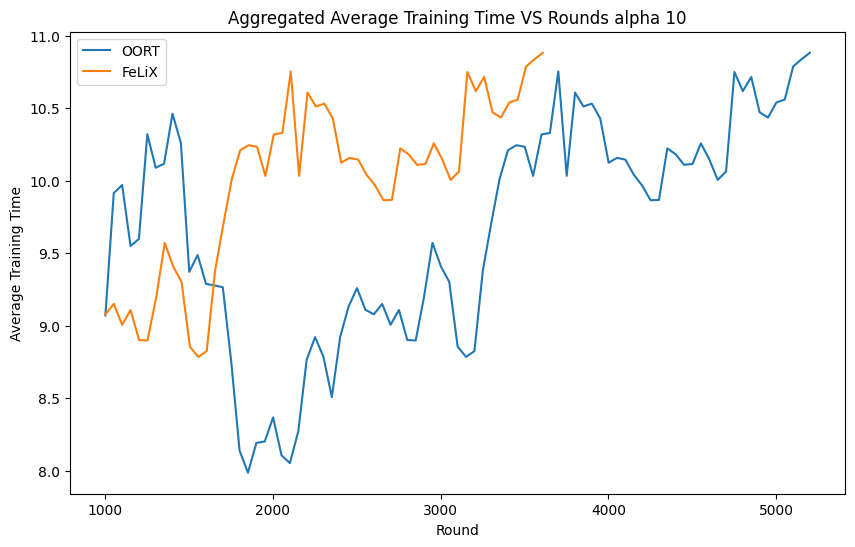

In [13]:
oort_agg_logs_alpha10 = 'filtered4_oort_alpha10.log'
felix_agg_logs_alpha10 = 'filtered4_felix_alpha10.log'
oort_output = get_avg_utility_staleness_vs_rounds(oort_agg_logs_alpha10, 2000)
felix_output = get_avg_utility_staleness_vs_rounds(felix_agg_logs_alpha10, 2000)
x, y = aggregate_values(oort_output)
x_oort = [value for value in x if value >= 1000]
y_oort = y[len(y) - len(x_oort):] 
x_f, y_f = aggregate_values(felix_output)
x_felix = [value for value in x_f if value >= 1000]
y_felix = y[len(y) - len(x_felix):] 
# x_oort = list(oort_output.keys())
# y_oort = list(oort_output.values())

plt.figure(figsize=(10, 6))
plt.plot(x_oort, y_oort, label='OORT')
plt.plot(x_felix, y_felix, label='FeLiX')
plt.xlabel("Round")
plt.ylabel("Average Training Time")
plt.title("Aggregated Average Training Time VS Rounds alpha 10")
plt.legend()
# plt.ylim(0,4)
plt.show()